imports

In [1]:
import pandas as pd
import shutil
import os
import librosa
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense





In [1]:
import os

def supprimer_fichiers_mp3(dossier):
    # Liste tous les fichiers dans le dossier
    fichiers = os.listdir(dossier)

    # Parcourir la liste des fichiers
    for fichier in fichiers:
        # Vérifier si le fichier a une extension MP3
        if fichier.endswith(".mp3"):
            # Construire le chemin complet du fichier
            chemin_fichier = os.path.join(dossier, fichier)

            # Supprimer le fichier
            os.remove(chemin_fichier)

            # Afficher un message
            print(f"Fichier {fichier} supprimé.")

# Spécifier le chemin du dossier où vous souhaitez supprimer les fichiers MP3
dossier_a_purger = "/Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/clips_test"

# Appeler la fonction pour supprimer les fichiers MP3
supprimer_fichiers_mp3(dossier_a_purger)


Fichier common_voice_fr_20422955.mp3 supprimé.
Fichier common_voice_fr_19332001.mp3 supprimé.
Fichier common_voice_fr_21028418.mp3 supprimé.
Fichier common_voice_fr_21673121.mp3 supprimé.
Fichier common_voice_fr_17912905.mp3 supprimé.
Fichier common_voice_fr_20389147.mp3 supprimé.
Fichier common_voice_fr_22020514.mp3 supprimé.
Fichier common_voice_fr_20035006.mp3 supprimé.
Fichier common_voice_fr_20874630.mp3 supprimé.
Fichier common_voice_fr_17308625.mp3 supprimé.
Fichier common_voice_fr_20864423.mp3 supprimé.
Fichier common_voice_fr_20790839.mp3 supprimé.
Fichier common_voice_fr_20401154.mp3 supprimé.
Fichier common_voice_fr_17940925.mp3 supprimé.
Fichier common_voice_fr_21928266.mp3 supprimé.
Fichier common_voice_fr_18601267.mp3 supprimé.
Fichier common_voice_fr_18091349.mp3 supprimé.
Fichier common_voice_fr_22291603.mp3 supprimé.
Fichier common_voice_fr_19586099.mp3 supprimé.
Fichier common_voice_fr_18658474.mp3 supprimé.
Fichier common_voice_fr_19043898.mp3 supprimé.
Fichier commo

EXTRAIRE UN DATAFRAME AVEC LES VOCAUX OU L AGE EST PRESENT

In [3]:
import pandas as pd

# Charger le fichier TSV dans un DataFrame en spécifiant index_col=False
file_path = '/Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/validated.tsv'
df = pd.read_csv(file_path, delimiter='\t', header=None, index_col=False)

# Ajuster les noms des colonnes
df.columns = df.iloc[0]

# Supprimer la première ligne car elle contient les noms de colonnes inutiles maintenant
df = df[1:]

# Filtrer les lignes avec des valeurs non nulles dans la colonne 'age'
df_filtered = df[df['age'].notnull()]

# Regrouper les classes d'âge comme souhaité
age_mapping = {
    'twenties': 'twenties_thirties',
    'thirties': 'twenties_thirties',
    'fourties': 'fourties_fifties',
    'fifties': 'fourties_fifties',
    'sixties': 'sixties_seventies_eighties',
    'seventies': 'sixties_seventies_eighties',
    'eighties': 'sixties_seventies_eighties',  
}

df_filtered['age'] = df_filtered['age'].replace(age_mapping)

# Afficher le DataFrame résultant
print(df_filtered[['path', 'age']])


/var/folders/bg/n7bsh58n7698sm_8ljpsbldr0000gn/T/ipykernel_1192/2487943043.py:5: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t', header=None, index_col=False)


0                               path                age
4       common_voice_fr_20656130.mp3  twenties_thirties
12      common_voice_fr_17960551.mp3  twenties_thirties
14      common_voice_fr_20344723.mp3  twenties_thirties
15      common_voice_fr_17623671.mp3              teens
16      common_voice_fr_18648580.mp3   fourties_fifties
...                              ...                ...
413085  common_voice_fr_22393640.mp3   fourties_fifties
413086  common_voice_fr_22393638.mp3   fourties_fifties
413087  common_voice_fr_22393637.mp3   fourties_fifties
413088  common_voice_fr_22393639.mp3   fourties_fifties
413089  common_voice_fr_22393641.mp3   fourties_fifties

[298284 rows x 2 columns]


/var/folders/bg/n7bsh58n7698sm_8ljpsbldr0000gn/T/ipykernel_1192/2487943043.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age'] = df_filtered['age'].replace(age_mapping)


REPARTITION DES AGES POUR CHOIX DE LA TAILLE DU DATASET D ENTRAINEMENT

In [4]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution = df_filtered['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution)


age
twenties_thirties             165600
fourties_fifties               99089
sixties_seventies_eighties     20093
teens                          13502
Name: count, dtype: int64


In [5]:
# on peut voir qu il y a enormements d echantillon dans chaque classe a part eighties. On va d abord esssayer d entrainer le modele sur une base de donees bien plus courte mais plus fournie que la premiere (3500 dont la moitie etait de la classe thirties). comme la distribution est bien plus homogene on va prendre une petite bdd la plus petite possible

creation echantillon entrainement

In [6]:

# Définir le nombre d'échantillons par classe
sample_size = 10000

# Créer un DataFrame vide pour stocker les échantillons sélectionnés
df_filtered2 = pd.DataFrame()

# Grouper le DataFrame par la colonne 'age'
grouped_df = df_filtered.groupby('age')

# Sélectionner aléatoirement sample_size lignes de chaque groupe
for group, group_df in grouped_df:
    sampled_rows = group_df.sample(min(sample_size, len(group_df)))
    df_filtered2 = pd.concat([df_filtered2, sampled_rows])

# Réinitialiser l'index du DataFrame résultant
df_filtered2 = df_filtered2.reset_index(drop=True)

# Afficher le DataFrame résultant
print(df_filtered2[['path', 'age']])

all_paths= df_filtered2['path'].tolist()



# Définir le nouveau répertoire de destination
destination_directory = "/Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/clips_test"

# Copier les fichiers vers le nouveau répertoire
for audio_file in all_paths:
    source_path = os.path.join("/Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/clips", audio_file)

    # Vérifier si le fichier source existe avant de le copier
    if os.path.exists(source_path):
        destination_path = os.path.join(destination_directory, audio_file)
        shutil.copy(source_path, destination_path)
    # Aucun affichage si le fichier source n'existe pas

print(f"{len(all_paths)} fichiers ont été copiés vers {destination_directory}.")


0                              path                age
0      common_voice_fr_20181379.mp3   fourties_fifties
1      common_voice_fr_19944274.mp3   fourties_fifties
2      common_voice_fr_20277229.mp3   fourties_fifties
3      common_voice_fr_20665783.mp3   fourties_fifties
4      common_voice_fr_17321901.mp3   fourties_fifties
...                             ...                ...
39995  common_voice_fr_20469099.mp3  twenties_thirties
39996  common_voice_fr_18913683.mp3  twenties_thirties
39997  common_voice_fr_17348285.mp3  twenties_thirties
39998  common_voice_fr_22043645.mp3  twenties_thirties
39999  common_voice_fr_17970887.mp3  twenties_thirties

[40000 rows x 2 columns]
40000 fichiers ont été copiés vers /Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/clips_test.


In [7]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution = df_filtered2['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution)

age
fourties_fifties              10000
sixties_seventies_eighties    10000
teens                         10000
twenties_thirties             10000
Name: count, dtype: int64


creation et affichage du nouvel echantillon d entrainement

In [8]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution2 = df_filtered2['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution2)


age
fourties_fifties              10000
sixties_seventies_eighties    10000
teens                         10000
twenties_thirties             10000
Name: count, dtype: int64


avoir la duree des enregistrements

In [9]:

# Fonction pour obtenir la durée d'un fichier audio en secondes
def get_audio_duration(file_path):
    audio, _ = librosa.load(file_path, sr=None)
    duration = len(audio) / _  # Durée en secondes
    return duration

# Ajouter une colonne de durée au DataFrame df_filtered
df_filtered2['duration'] = df_filtered2['path'].apply(lambda x: get_audio_duration(os.path.join(destination_directory, x)))

# Afficher le DataFrame résultant
print(df_filtered2)

0                                              client_id  \
0      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
1      72f64e8889ee50ec238cb39b384e715615c6761aa4e705...   
2      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
3      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
4      88d17dd9927ee504b7bce1e7ce13f5656c70dc7ef4db05...   
...                                                  ...   
39995  b5c6eb9fcb6cf714c4cef913529d45f8ffe4214e6c4305...   
39996  050a413c7882b08d74a33bb4ff54c3e820850af5f4c6fa...   
39997  497d2b62867b8a81ac82eb51b815662a2795ab2c1abbcf...   
39998  8762d0ad541908be07db8fda7e5d2d4cb258d27eac59f6...   
39999  432d4b5f727f33bb27f454eb8e900b71ddf3ced6b95ff6...   

0                              path  \
0      common_voice_fr_20181379.mp3   
1      common_voice_fr_19944274.mp3   
2      common_voice_fr_20277229.mp3   
3      common_voice_fr_20665783.mp3   
4      common_voice_fr_17321901.mp3   
...                             ...   
39995 

In [10]:
# Obtenez des statistiques sur la colonne 'duration'
duration_stats = df_filtered2['duration'].describe()

# Affichez les statistiques
print(duration_stats)

count    40000.000000
mean         4.682845
std          1.712068
min          0.624000
25%          3.408000
50%          4.608000
75%          5.856000
max         10.944000
Name: duration, dtype: float64


In [11]:
#on peut voir que 75% des audios ont une duree de plus de 3.57 secondes

In [12]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

# Fonction pour charger le fichier audio et obtenir le signal sous forme de vecteur 1D
def load_audio(file_path):
    # Chargement du fichier audio
    y, sr = librosa.load(file_path, sr=None)  # Ajout de sr=None pour obtenir le taux d'échantillonnage
    return y, sr

def preprocess_audio(file_path, max_duration=3.5):
    # Charger le fichier audio avec Librosa
    audio, sr = librosa.load(file_path, duration=max_duration)

    # Tronquer ou remplir le signal pour qu'il ait la même longueur que max_duration * sr
    target_length = int(max_duration * sr)
    
    if len(audio) > target_length:
        audio = audio[:target_length]
    
    return audio, sr  

# Chemin du dossier contenant les fichiers audio
destination_directory = "/Users/leohanifi/PycharmProjects/pythonProject/cv-corpus-5.1-2020-06-22/fr/clips_test"
X = []  # Liste pour stocker les vecteurs 1D des signaux audio
# Liste pour stocker les chemins des fichiers à conserver dans le DataFrame
files_to_keep = []


# Parcourir le DataFrame pour traiter les fichiers audio
for idx in tqdm(range(len(df_filtered2)), desc='Traitement des signaux audio', colour='white'):
    file_name = df_filtered2.iloc[idx]['path']
    filepath = os.path.join(destination_directory, file_name)

    # Appliquer la fonction de prétraitement sans spécifier la durée maximale
    audio_signal, sr = preprocess_audio(filepath)

    # Vérifier si la durée est supérieure ou égale à 3.5 secondes
    if len(audio_signal) == int(3.5 * sr):
        # Ajouter le vecteur 1D à la liste X
        X.append(audio_signal)
        
        # Ajouter le chemin du fichier au DataFrame
        files_to_keep.append(idx)
    else:
        # Supprimer le fichier s'il est inférieur à 3.5 secondes
        os.remove(filepath)
        
# Filtrer le DataFrame pour ne conserver que les lignes avec des durées >= 3.5 secondes
df_filtered2 = df_filtered2.iloc[files_to_keep]

print(df_filtered2)
# Calculer la durée maximale après avoir rempli la liste X
max_duration = max(len(audio) for audio in X) / sr


Traitement des signaux audio: 100%|██████████| 40000/40000 [01:53<00:00, 353.80it/s]


0                                              client_id  \
0      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
1      72f64e8889ee50ec238cb39b384e715615c6761aa4e705...   
2      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
3      ee74e15cc2cfe71d23fd8c9e743b26d6913c64c315f708...   
4      88d17dd9927ee504b7bce1e7ce13f5656c70dc7ef4db05...   
...                                                  ...   
39991  55e311cdba34f70be4760c1af7f0bcf66afb2bf5b94c35...   
39992  5ea7e4e411a2e8e20823a1e5750611a5cae1584a7ef69b...   
39994  710114a98a90eb6da2c7be4544e5983e0246a9714080e5...   
39995  b5c6eb9fcb6cf714c4cef913529d45f8ffe4214e6c4305...   
39997  497d2b62867b8a81ac82eb51b815662a2795ab2c1abbcf...   

0                              path  \
0      common_voice_fr_20181379.mp3   
1      common_voice_fr_19944274.mp3   
2      common_voice_fr_20277229.mp3   
3      common_voice_fr_20665783.mp3   
4      common_voice_fr_17321901.mp3   
...                             ...   
39991 

In [13]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution2 = df_filtered2['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution2)

age
fourties_fifties              8186
sixties_seventies_eighties    8183
twenties_thirties             7155
teens                         5879
Name: count, dtype: int64


In [14]:
# Nombre de valeurs à supprimer pour une seconde
valeurs_a_supprimer = 22050

def supprimer_premieres_secondes(intensity_list, valeurs_a_supprimer):
    return intensity_list[valeurs_a_supprimer:]

# Créer une nouvelle liste X_sans_premieres_secondes
X= [supprimer_premieres_secondes(sublist, valeurs_a_supprimer) for sublist in X]


# Afficher les valeurs après suppression des premières secondes (premier élément à titre d'exemple)

print(len(X[0]))


55125


In [15]:
X= np.vstack(X)
print(X)






[[ 1.05040036e-01  5.84119633e-02  6.27959371e-02 ...  1.25671475e-04
   5.69358162e-05 -8.75359110e-05]
 [-3.51294689e-02 -3.22743952e-02 -1.10823372e-02 ... -4.51770097e-01
  -4.32397604e-01 -4.79079366e-01]
 [ 4.66411039e-02  3.74379084e-02  2.69608609e-02 ... -2.07841769e-02
   2.41101347e-02 -5.82699254e-02]
 ...
 [ 3.59642669e-04  2.95620848e-04  2.70491524e-04 ...  3.09028401e-04
   3.17497528e-04  2.76390405e-04]
 [-7.86681026e-02 -2.84127835e-02 -3.05884331e-02 ... -3.52153159e-03
   1.22072352e-02  2.67688669e-02]
 [-1.40491081e-02 -9.98535380e-03 -1.04107270e-02 ... -5.49027463e-04
  -5.93935663e-04 -6.21362065e-04]]


In [16]:
# Créer un mapping personnalisé pour le label encoding
age_label_mapping = {'teens': 1, 'twenties_thirties': 2, 'fourties_fifties': 3, 'sixties_seventies_eighties': 4}

# Appliquer le mapping pour créer une nouvelle colonne 'y_age_encoded'
df_filtered2['y_age_encoded'] = df_filtered2['age'].map(age_label_mapping)

# Utiliser 'y_age_encoded' comme variable cible 'y'
y = df_filtered2['y_age_encoded'].tolist()

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print(y_categorical)
print(y)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [18]:

from sklearn.preprocessing import MinMaxScaler
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Création du modèle CNN1D simple
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)



In [22]:
from sklearn.metrics import accuracy_score

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test) , callbacks=[early_stopping])

# Évaluation du modèle sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes_normalized = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy_normalized = accuracy_score(y_test_classes, y_pred_classes_normalized)

print(f"Accuracy on normalized test set: {accuracy_normalized}")


Epoch 1/30
736/736 [==============================] - 642s 871ms/step - loss: 1.3042 - accuracy: 0.3654 - val_loss: 1.2780 - val_accuracy: 0.3741
Epoch 2/30
736/736 [==============================] - 694s 943ms/step - loss: 1.2797 - accuracy: 0.3895 - val_loss: 1.2620 - val_accuracy: 0.3999
Epoch 3/30
736/736 [==============================] - 706s 958ms/step - loss: 1.2618 - accuracy: 0.4012 - val_loss: 1.2444 - val_accuracy: 0.4149
Epoch 4/30
736/736 [==============================] - 721s 979ms/step - loss: 1.2543 - accuracy: 0.4041 - val_loss: 1.2355 - val_accuracy: 0.4265
Epoch 5/30
736/736 [==============================] - 719s 977ms/step - loss: 1.2442 - accuracy: 0.4128 - val_loss: 1.2248 - val_accuracy: 0.4302
Epoch 6/30
736/736 [==============================] - 722s 981ms/step - loss: 1.2358 - accuracy: 0.4219 - val_loss: 1.2185 - val_accuracy: 0.4379
Epoch 7/30
736/736 [==============================] - 716s 973ms/step - loss: 1.2299 - accuracy: 0.4245 - val_loss: 1.2294 -

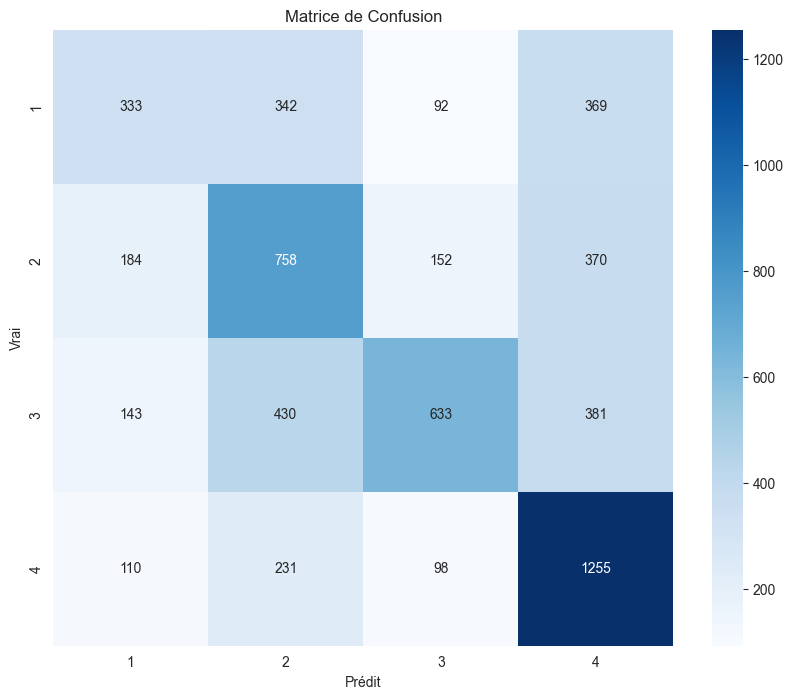

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



# Matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes_normalized)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()



In [24]:

# Rapport de classification
class_report = classification_report(y_test_classes, y_pred_classes_normalized)
print("Rapport de Classification:\n", class_report)

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.43      0.29      0.35      1136
           1       0.43      0.52      0.47      1464
           2       0.65      0.40      0.49      1587
           3       0.53      0.74      0.62      1694

    accuracy                           0.51      5881
   macro avg       0.51      0.49      0.48      5881
weighted avg       0.52      0.51      0.50      5881


In [25]:


# Extraction des données d'historique
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracer les courbes d'accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tracer les courbes de loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Afficher les graphiques
plt.show()


Epoch 1/30
 10/736 [..............................] - ETA: 9:41 - loss: 1.0813 - accuracy: 0.5562

KeyboardInterrupt: 